# CNN analysis of pooling indexes
This analyzes is dependent on what is defined within the network class. Meaning what area of the input is extracted is defined within the network class. This is suboptimal, but works for now. Dont exectute code cells that you are not trying to alter


### Load Libraries

In [1]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torch import nn, cuda
from torch.utils.data.dataloader import DataLoader
from utils import Runner, TcrDataset, setup_seed
from cnn_network import CdrCNN
import pandas as pd

In [2]:
def reverse_one_hot(arr):
        mapping = dict(zip(range(20), "ACDEFGHIKLMNPQRSTVWY"))
        seq = ""
        for j in range(arr.shape[1]):
            pos = arr[:, j]
            if not np.all(pos==0):
                seq += mapping[np.argmax(pos)]
        return seq

Set general plotting parameters for matplotlib using seaborn

In [3]:
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params, palette="pastel")

### General parameters

In [4]:
# General parameters
data_dir = "../../data/"
data_files = [data_dir+f"datasets/P{i}_input_cdrs.npz" for i in range(1,6)]
label_files = [data_dir+f"datasets/P{i}_labels.npz" for i in range(1,6)]
model_name = "cdr_model.pt"
model_path = "stored_models/"

batch_size = 64
seed= 42

setup_seed(seed)
device = torch.device("cuda" if cuda.is_available() else "cpu")
#device= torch.device("cpu")

## Define indexing

In [5]:
# Peptide + All CDRS
idx = np.arange(179,248)

# Sequence
local_features = np.arange(20)
global_features = None
use_global_features = False


## Load Data
Partitions can be changed by altering the `data_files` and `label_files` indexing

In [6]:
test_data = TcrDataset(data_files[4], label_files[4])
test_one_hot = TcrDataset(data_files[4], label_files[4])

# slicing sequence dimension
test_one_hot.slice_sequences(idx)
test_data.slice_sequences(idx)
test_data.to_blossum()

input_len = test_data.data.shape[2]

In [7]:
test_dl = DataLoader(test_data, batch_size)

In [8]:
test_data.data.shape

(1207, 54, 69)

In [9]:
# Layer parameters
cnn_channels = 20
hidden_neurons = 64
dropout = 0.4
cnn_kernel = 3

loss_weight = len(test_data) / sum(test_data.labels)
criterion = nn.BCELoss(reduction='none')

In [10]:
net = CdrCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel, dense_neurons=hidden_neurons)
net.load_state_dict(torch.load(model_path + model_name))
net.to(device)
initial_net = CdrCNN(local_features, global_features, use_global_features, cnn_channels=cnn_channels, dropout=dropout, cnn_kernel_size=cnn_kernel, dense_neurons=hidden_neurons)
initial_net.to(device)

test_runner = Runner(test_dl, net, criterion, loss_weight, device)

Also load data as only one observed peptide. Meaning that there will only be 16 observations. This is to avoid having the GIL peptide overshadow what positions are important for the general peptide population. The reason can be seen by the peptide counts shown below.

In [11]:
peptides = test_one_hot.data[:, :20, :9]
peptides = np.array([reverse_one_hot(peptides[i]) for i in range(len(peptides))])
peptide_counts = np.unique(peptides, return_counts=True)
peptide_counts

(array(['CLGGLLTMV', 'FLYALALLL', 'GILGFVFTL', 'GLCTLVAML', 'IMDQVPFSV',
        'KLQCVDLHV', 'KTWGQYWQV', 'KVLEYVIKV', 'LLFGYPVYV', 'MLDLQPETT',
        'NLVPMVATV', 'RMFPNAPYL', 'RTLNAWVKV', 'SLFNTVATL', 'SLLMWITQV',
        'YLLEMLWRL'], dtype='<U9'),
 array([  2,  22, 686, 239,   6,   2,  15,   6,  37,   7, 136,   9,  18,
          5,  10,   7]))

In [12]:
peptide_indexes = [np.where(peptides == peptide)[0][0] for peptide in peptide_counts[0]]
unique_pep_data = test_runner.loader.dataset.data[peptide_indexes]
unique_pep_labels = test_runner.loader.dataset.labels[peptide_indexes]
unique_dataset = [[data[0], data[1]] for data in zip(unique_pep_data, unique_pep_labels)]
unique_dl = DataLoader(unique_dataset, batch_size=batch_size)
unique_runner = Runner(unique_dl, net, criterion, loss_weight, device)

## Analysis of Max pooling indexes
The hyptothesis here is based on how the CNN and maxpooling would interact. The hope is that one filter learns specific things, that are important for each position in the peptide/cdrs. By looking at the max pooling indexes we can see what position contributes with information in the dense layer. 

I need to know the amount of peptides in each group since there is big imbalance, and since we are only looking at peptide first. All identical peptides would pool in the same manner.

### Unique peptide analysis
Count the number of times each position is selected when doing maxpooling. Done for only unique peptides here

In [13]:
len(unique_dataset)

16

In [14]:
max_pool, idxs = unique_runner.get_pool_idxs("pep")

total_counts = np.zeros((11))
start_pos = np.zeros((11))
for i, filter in enumerate(idxs):
    positions, counts = torch.unique(filter, return_counts=True)
    for pos, count in zip(positions, counts):
        total_counts[pos] += count
        total_counts[pos+1] += count
        total_counts[pos+2] += count
        start_pos[pos] += count
        

Total number of counts is $ n_{filters} \cdot n_{obs} \cdot kernelSize $ ($3 \cdot 16 \cdot 3 = 144$)

Doing the same analysis on a completely new network might show a different distribution of chosen positions

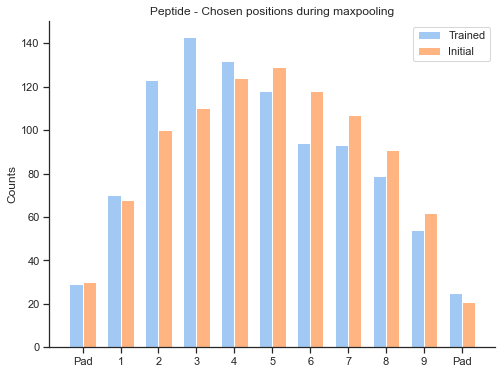

In [15]:
unique_runner.model = initial_net
pool_out, idxs = unique_runner.get_pool_idxs("pep")

total_counts_init = np.zeros((11))
start_pos_init = np.zeros((11))
for i, filter in enumerate(idxs):
    positions, counts = torch.unique(filter, return_counts=True)
    for pos, count in zip(positions, counts):
        total_counts_init[pos] += count
        total_counts_init[pos+1] += count
        total_counts_init[pos+2] += count
        start_pos_init[pos] += count


labels = ["Pad", "1", "2", "3", "4", "5", "6", "7", "8", "9", "Pad"]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars


fig, ax = plt.subplots(figsize=(8,6))
rects1 = ax.bar(x - width/2, total_counts, width, label='Trained')
rects2 = ax.bar(x + width/2, total_counts_init, width, label='Initial')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Peptide - Chosen positions during maxpooling')
ax.set_xticks(x, labels)
ax.legend()

unique_runner.model = net

Keep in mind that more filters are overlapping with the middle positions, than the outlier positions. When looking at the possible filter positions that are possible.

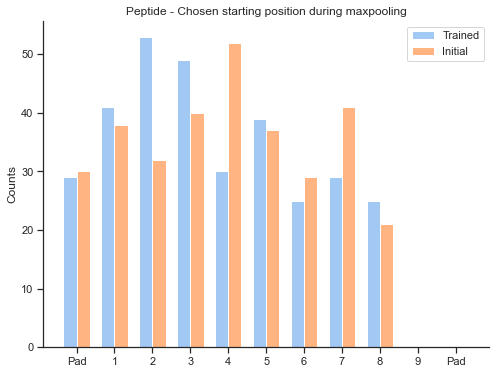

In [16]:
fig, ax = plt.subplots(figsize=(8,6))

rects1 = ax.bar(x - width/2, start_pos, width, label='Trained')
rects2 = ax.bar(x + width/2, start_pos_init, width, label='Initial')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Counts')
ax.set_title('Peptide - Chosen starting position during maxpooling')
ax.set_xticks(x, labels)
ax.legend()


The peptide cannot start with position 9 Since the kernel will only be 9 long. The filter starting at first pad and 8 cannot be chosen either, since they contain padding.

## CDR3b analysis

### General analysis of 1 TCR or all summed
Count the number of times each position is selected when doing maxpooling. Done for all peptides here.

In [17]:
pool_out, idxs = test_runner.get_pool_idxs("cdr3b")
test_runner.model = initial_net
pool_out_init, idxs_init = test_runner.get_pool_idxs("cdr3b")
test_runner.model = net

Plot showing maxpooling positions for a specific cdr3b summed over all filters

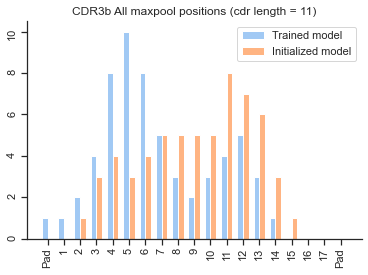

Text(0.5, 1.0, 'CDR3b Maxpool pos initial model (cdr length = 11)')

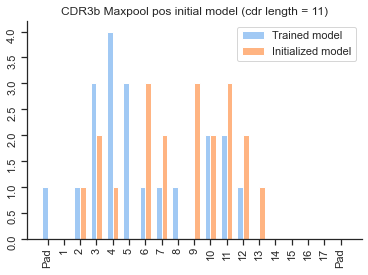

In [18]:
total_counts = np.zeros((idxs.shape[1],19))
start_pos = np.zeros((idxs.shape[1],19))
for i in range(idxs.shape[1]):
    for idx in idxs[:, i]:
        start_pos[i, idx] += 1
        total_counts[i, idx] += 1
        total_counts[i, idx+1] += 1
        total_counts[i, idx+2] += 1

total_counts_init = np.zeros((idxs.shape[1],19))
start_pos_init = np.zeros((idxs.shape[1],19))
for i in range(idxs.shape[1]):
    for idx in idxs_init[:, i]:
        start_pos_init[i, idx] += 1
        total_counts_init[i, idx] += 1
        total_counts_init[i, idx+1] += 1
        total_counts_init[i, idx+2] += 1

labels = ["Pad"]+[str(x) for x in range(1,18)] + ["Pad"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

obs = 0 # Change here for altering observation
cdr_len = len(reverse_one_hot(test_one_hot.data[obs, :20, 24:39]))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, total_counts[obs,:], width, label='Trained model')
rects2 = ax.bar(x + width/2, total_counts_init[obs,:], width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3b All maxpool positions (cdr length = {cdr_len})")
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, start_pos[obs,:], width, label='Trained model')
rects2 = ax.bar(x + width/2, start_pos_init[obs,:], width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3b Maxpool pos initial model (cdr length = {cdr_len})")

Plot showing all maxpooling dimensions of filters for cdr3b summed over filters and observations

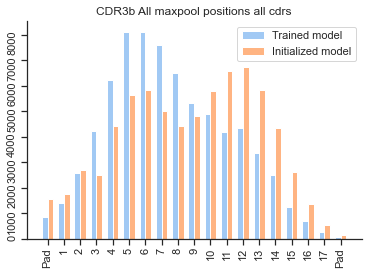

Text(0.5, 1.0, 'CDR3b Maxpool pos initial model all cdrs')

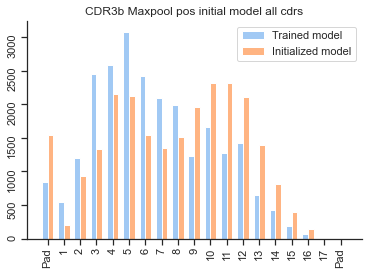

In [19]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(total_counts, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(total_counts_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3b All maxpool positions all cdrs")
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(start_pos, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(start_pos_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3b Maxpool pos initial model all cdrs")

### CDR3b per peptide motif for maxpooling

In [20]:
cdr3b_filter = dict()
for i, obs in enumerate(test_data):
    pep = reverse_one_hot(obs[0][:20,:9])
    cdr_b = reverse_one_hot(obs[0][:20,52:])
    if obs[1] == 1:
        if pep not in cdr3b_filter:
            cdr3b_filter[pep] = {len(cdr_b) : [i]}
        elif len(cdr_b) not in cdr3b_filter[pep]:
            cdr3b_filter[pep][len(cdr_b)] = [i]
        else:
            cdr3b_filter[pep][len(cdr_b)].append(i)

In [21]:
# 'GILGFVFTL', 'GLCTLVAML', 'NLVPMVATV', 'LLFGYPVYV', 'FLYALALLL',
# 'RTLNAWVKV', 'KTWGQYWQV', 'SLLMWITQV', 'RMFPNAPYL', 'YLLEMLWRL',
# 'MLDLQPETT', 'KVLEYVIKV', 'IMDQVPFSV', 'SLFNTVATL', 'KLQCVDLHV',
# 'CLGGLLTMV'
peptide = "GILGFVFTL"
length = 12

[print(lnth, len(cdr3b_filter[peptide][lnth])) for lnth in cdr3b_filter[peptide]]
idxs = cdr3b_filter[peptide][length]
test_data.subset_datapoints(idxs)
subset_ldr = DataLoader(test_data, batch_size=batch_size)
subset_runner = Runner(subset_ldr, net, criterion, loss_weight, device)


12 136
13 16
14 18
16 6
10 3
15 10
11 11
17 3


In [22]:
pool_out, idxs = subset_runner.get_pool_idxs("cdr3b")
subset_runner.model = initial_net
pool_out_init, idxs_init = subset_runner.get_pool_idxs("cdr3b")
subset_runner.model = net

Plot of maxpooling positions for a specific length of cdr3b with a specific peptide

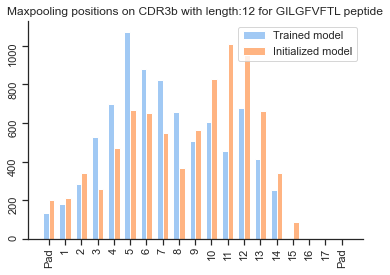

Text(0.5, 1.0, 'Maxpooling filter start on CDR3b with length:12 for GILGFVFTL peptide')

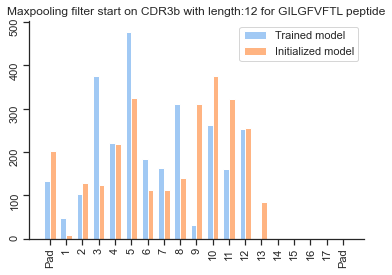

In [23]:
total_counts = np.zeros((idxs.shape[1],19))
start_pos = np.zeros((idxs.shape[1],19))
for i in range(idxs.shape[1]):
    for idx in idxs[:, i]:
        start_pos[i, idx] += 1
        total_counts[i, idx] += 1
        total_counts[i, idx+1] += 1
        total_counts[i, idx+2] += 1

total_counts_init = np.zeros((idxs.shape[1],19))
start_pos_init = np.zeros((idxs.shape[1],19))
for i in range(idxs.shape[1]):
    for idx in idxs_init[:, i]:
        start_pos_init[i, idx] += 1
        total_counts_init[i, idx] += 1
        total_counts_init[i, idx+1] += 1
        total_counts_init[i, idx+2] += 1

labels = ["Pad"]+[str(x) for x in range(1,18)] + ["Pad"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(total_counts, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(total_counts_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling positions on CDR3b with length:{length} for {peptide} peptide")
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(start_pos, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(start_pos_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling filter start on CDR3b with length:{length} for {peptide} peptide")

Or it can be counted for an indivdual filter defined in block below

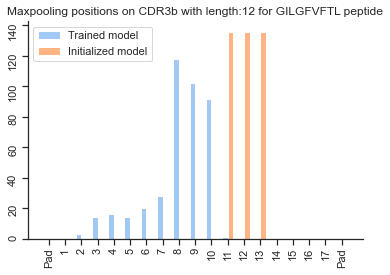

Text(0.5, 1.0, 'Maxpooling filter start on CDR3b with length:12 for GILGFVFTL peptide')

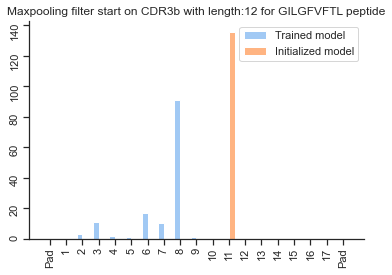

In [24]:
filter = 0
total_counts = np.zeros((idxs.shape[0], idxs.shape[1],19))
start_pos = np.zeros((idxs.shape[0], idxs.shape[1],19))
for i in range(idxs.shape[0]):
    for j in range(idxs.shape[1]):
        start_pos[i, j, idxs[i,j]] += 1
        total_counts[i, j, idxs[i,j]] += 1
        total_counts[i, j, idxs[i,j]+1] += 1
        total_counts[i, j, idxs[i,j]+2] += 1

total_counts_init = np.zeros((idxs_init.shape[0], idxs_init.shape[1],19))
start_pos_init = np.zeros((idxs_init.shape[0], idxs_init.shape[1],19))
for i in range(idxs_init.shape[0]):
    for j in range(idxs_init.shape[1]):
        start_pos_init[i, j, idxs_init[i,j]] += 1
        total_counts_init[i, j, idxs_init[i,j]] += 1
        total_counts_init[i, j, idxs_init[i,j]+1] += 1
        total_counts_init[i, j, idxs_init[i,j]+2] += 1

labels = ["Pad"]+[str(x) for x in range(1,18)] + ["Pad"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(total_counts[filter], axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(total_counts_init[filter], axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling positions on CDR3b with length:{length} for {peptide} peptide")
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(start_pos[filter], axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(start_pos_init[filter], axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling filter start on CDR3b with length:{length} for {peptide} peptide")

In [25]:
per_pos_count = np.sum(total_counts, (0,1))
per_pos_count_init = np.sum(total_counts_init, (0,1))
np.mean(np.abs(per_pos_count - per_pos_count_init))

178.8421052631579

## CDR3a analysis

In [26]:
pool_out, idxs = test_runner.get_pool_idxs("cdr3a")
test_runner.model = initial_net
pool_out_init, idxs_init = test_runner.get_pool_idxs("cdr3a")
test_runner.model = net

Plot showing all the maxpoolin filters for a specific observation

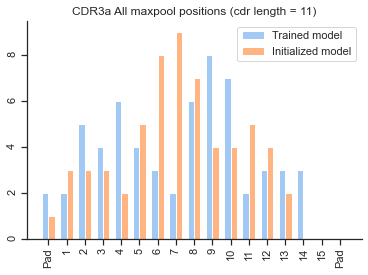

Text(0.5, 1.0, 'CDR3a Maxpool pos initial model (cdr length = 11)')

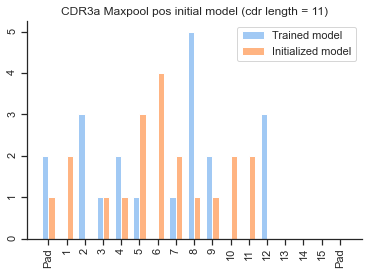

In [27]:
total_counts = np.zeros((idxs.shape[1],17))
start_pos = np.zeros((idxs.shape[1],17))
for i in range(idxs.shape[1]):
    for idx in idxs[:, i]:
        start_pos[i, idx] += 1
        total_counts[i, idx] += 1
        total_counts[i, idx+1] += 1
        total_counts[i, idx+2] += 1

total_counts_init = np.zeros((idxs.shape[1],17))
start_pos_init = np.zeros((idxs.shape[1],17))
for i in range(idxs.shape[1]):
    for idx in idxs_init[:, i]:
        start_pos_init[i, idx] += 1
        total_counts_init[i, idx] += 1
        total_counts_init[i, idx+1] += 1
        total_counts_init[i, idx+2] += 1

labels = ["Pad"]+[str(x) for x in range(1,16)] + ["Pad"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

obs = 0 # Change here for altering observation
cdr_len = len(reverse_one_hot(test_one_hot.data[obs, :20, 24:39]))
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, total_counts[obs,:], width, label='Trained model')
rects2 = ax.bar(x + width/2, total_counts_init[obs,:], width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3a All maxpool positions (cdr length = {cdr_len})")
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, start_pos[obs,:], width, label='Trained model')
rects2 = ax.bar(x + width/2, start_pos_init[obs,:], width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3a Maxpool pos initial model (cdr length = {cdr_len})")

Plot showing for all filters and all positions

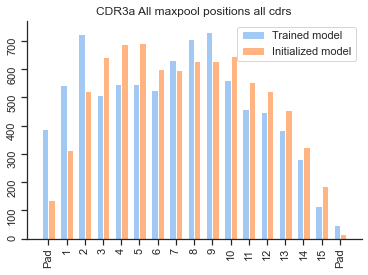

Text(0.5, 1.0, 'CDR3a Maxpool pos initial model all cdrs')

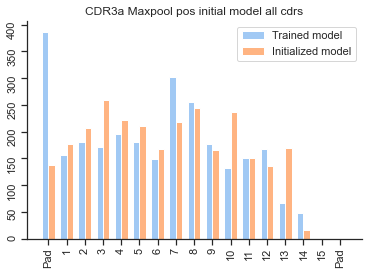

In [28]:
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(total_counts, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(total_counts_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3a All maxpool positions all cdrs")
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(start_pos, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(start_pos_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"CDR3a Maxpool pos initial model all cdrs")

## CDR3a per peptide analysis
Only look at TCRs with known positive binding to specific peptides

In [29]:
cdr3a_filter = dict()
test_data.subset_datapoints(np.arange(1207))
for i, obs in enumerate(test_data):
    pep = reverse_one_hot(obs[0][:20,:9])
    cdr_a = reverse_one_hot(obs[0][:20,24:39])
    if obs[1] == 1:
        if pep not in cdr3a_filter:
            cdr3a_filter[pep] = {len(cdr_a) : [i]}
        elif len(cdr_a) not in cdr3a_filter[pep]:
            cdr3a_filter[pep][len(cdr_a)] = [i]
        else:
            cdr3a_filter[pep][len(cdr_a)].append(i)

In [30]:
length = 14

[print(lnth, len(cdr3a_filter[peptide][lnth])) for lnth in cdr3a_filter[peptide]]
idxs = cdr3a_filter[peptide][length]
test_data.subset_datapoints(idxs)
subset_ldr = DataLoader(test_data, batch_size=batch_size)
subset_runner = Runner(subset_ldr, net, criterion, loss_weight, device)

11 40
14 78
13 37
15 13
9 1
12 29
10 5


In [31]:
pool_out, idxs = subset_runner.get_pool_idxs("cdr3a")
subset_runner.model = initial_net
pool_out_init, idxs_init = subset_runner.get_pool_idxs("cdr3a")
subset_runner.model = net

Plots showing maxpooling positions summed over all filters for cdr3a for specific peptide

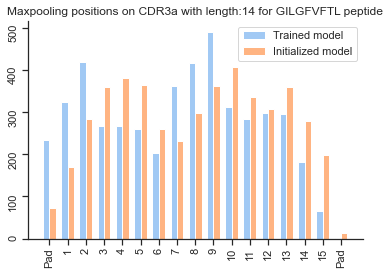

Text(0.5, 1.0, 'Maxpooling filter start on CDR3a with length:14 for GILGFVFTL peptide')

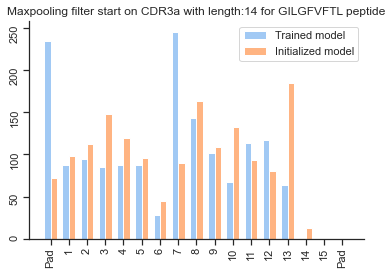

In [32]:
total_counts = np.zeros((idxs.shape[1],17))
start_pos = np.zeros((idxs.shape[1],17))
for i in range(idxs.shape[1]):
    for idx in idxs[:, i]:
        start_pos[i, idx] += 1
        total_counts[i, idx] += 1
        total_counts[i, idx+1] += 1
        total_counts[i, idx+2] += 1

total_counts_init = np.zeros((idxs.shape[1],17))
start_pos_init = np.zeros((idxs.shape[1],17))
for i in range(idxs.shape[1]):
    for idx in idxs_init[:, i]:
        start_pos_init[i, idx] += 1
        total_counts_init[i, idx] += 1
        total_counts_init[i, idx+1] += 1
        total_counts_init[i, idx+2] += 1

labels = ["Pad"]+[str(x) for x in range(1,16)] + ["Pad"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(total_counts, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(total_counts_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling positions on CDR3a with length:{length} for {peptide} peptide")
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(start_pos, axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(start_pos_init, axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling filter start on CDR3a with length:{length} for {peptide} peptide")

Plots showing maxpooling positions for filter decided from below

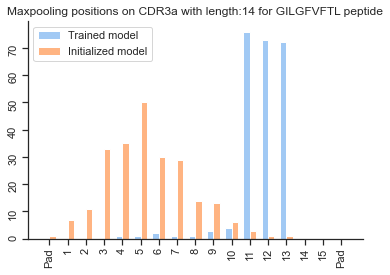

Text(0.5, 1.0, 'Maxpooling filter start on CDR3a with length:14 for GILGFVFTL peptide')

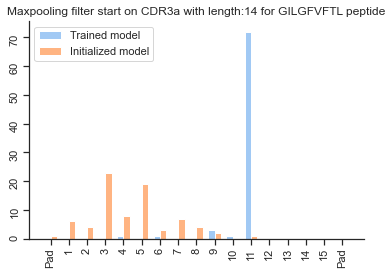

In [33]:
filter = 1
total_counts = np.zeros((idxs.shape[0], idxs.shape[1],17))
start_pos = np.zeros((idxs.shape[0], idxs.shape[1],17))
for i in range(idxs.shape[0]):
    for j in range(idxs.shape[1]):
        start_pos[i, j, idxs[i,j]] += 1
        total_counts[i, j, idxs[i,j]] += 1
        total_counts[i, j, idxs[i,j]+1] += 1
        total_counts[i, j, idxs[i,j]+2] += 1

total_counts_init = np.zeros((idxs_init.shape[0], idxs_init.shape[1],17))
start_pos_init = np.zeros((idxs_init.shape[0], idxs_init.shape[1],17))
for i in range(idxs_init.shape[0]):
    for j in range(idxs_init.shape[1]):
        start_pos_init[i, j, idxs_init[i,j]] += 1
        total_counts_init[i, j, idxs_init[i,j]] += 1
        total_counts_init[i, j, idxs_init[i,j]+1] += 1
        total_counts_init[i, j, idxs_init[i,j]+2] += 1

labels = ["Pad"]+[str(x) for x in range(1,16)] + ["Pad"]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(total_counts[filter], axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(total_counts_init[filter], axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling positions on CDR3a with length:{length} for {peptide} peptide")
plt.show()

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, np.sum(start_pos[filter], axis=0), width, label='Trained model')
rects2 = ax.bar(x + width/2, np.sum(start_pos_init[filter], axis=0), width, label='Initialized model')
ax.tick_params(rotation=90)
ax.set_xticks(x, labels)
ax.legend()
ax.set_title(f"Maxpooling filter start on CDR3a with length:{length} for {peptide} peptide")

To investigate whether the number of changes in filters can serve as a proxy for how important the feature is (alpha chain vs beta chain) the difference between each filter is calculated and then. The idea being that if there is a large gain in performance if this filter is important, then the loss function will have a large effect on the weights describing it, and force a larger change upon this filter.

In [34]:
per_pos_count = np.sum(total_counts, (0,1))
per_pos_count_init = np.sum(total_counts_init, (0,1))
np.mean(np.abs(per_pos_count - per_pos_count_init))

97.41176470588235

## Check results from CV experiment to see per peptide performance

For now only has the performance of the CDRs

In [191]:
result = pd.read_csv("../../results/modelling/CdrCNN_cdr_scores.csv", index_col=0)

In [192]:
from sklearn import metrics
def calc_auc(x):
    d = {}
    d["auc"] = metrics.roc_auc_score(x["labels"],x["scores"])
    d["counts"] = len(x)
    return pd.Series(d, index=["auc", "counts"])

result = result[result["peptide"].isin(result["peptide"].value_counts(ascending=False).head(10).index)]
auc_df = result.groupby("peptide").apply(calc_auc)

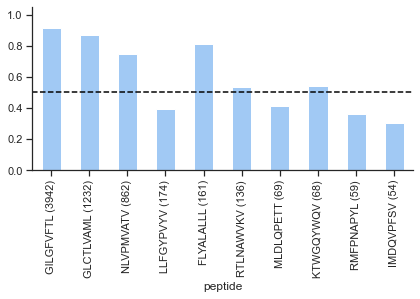

In [201]:
def get_labels(x):
    return f"{x.name} ({int(x['counts'])})"

auc_df = auc_df.sort_values("counts",ascending=False)
ax = auc_df.plot.bar(y="auc",ylim=[0,1.05])
ax.axhline(0.5, ls="--", c="black")
plt.tight_layout()
ax.get_legend().remove()
ax.set_xticklabels(auc_df.apply(get_labels, axis=1))
plt.savefig("../../results/modelling/cdr_peptide_auc.png")